In [37]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


# Load behavioral data

In [38]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()

df = df[df.study == 'szeged']

# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

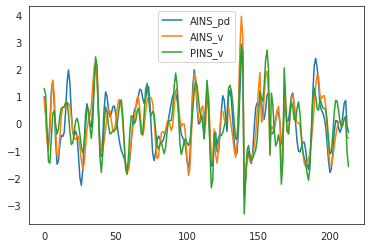

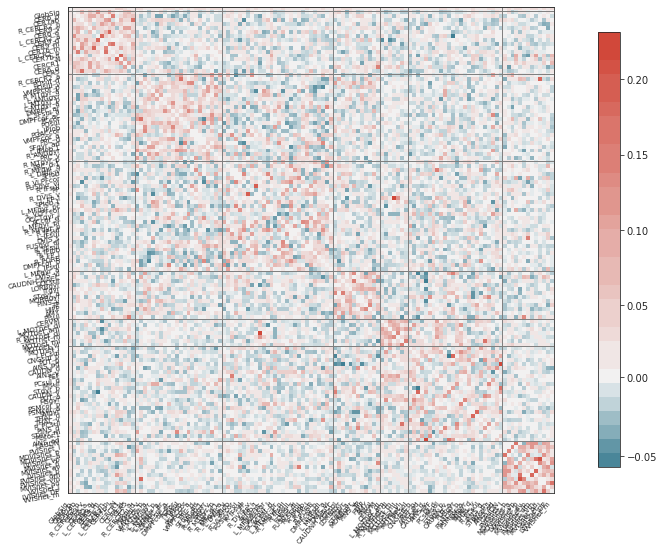

In [39]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [40]:
X.shape

(19, 123, 123)

# Load participant-level connectivity data

In [41]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
#mc_model = mc_model[mc_model['abs_multi-center']>0.02]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    #conns_mc_model(i_a, i_b)
    conns_mc_model[:, idx] = X[:, i_a, i_b]
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.020078,-0.058732,-0.000201,0.016037,0.129990,0.040014,0.021287,0.047699,-0.003944,0.012494,...,0.048669,-0.051505,0.072252,-0.005557,0.003200,0.082997,-0.106591,0.004689,0.009444,0.006734
1,0.010746,0.014871,-0.042046,0.110011,0.162331,0.030911,-0.022936,0.029736,0.012002,-0.096737,...,-0.015987,-0.000850,-0.057780,0.011663,-0.021371,0.029735,-0.015657,-0.016863,-0.097975,-0.025792
2,0.023161,0.017127,-0.014836,-0.027592,0.152169,0.002929,0.032231,-0.003182,0.086500,0.105450,...,-0.001019,-0.022715,0.073561,0.030870,-0.010019,-0.003953,-0.008944,0.010320,0.021193,-0.003916
3,0.005046,0.077336,-0.142694,-0.060617,0.149749,0.025141,-0.037958,0.002443,0.027514,-0.086270,...,0.027345,-0.002005,0.017126,0.046418,0.025556,0.032819,-0.080856,0.004260,0.001599,0.098450
4,0.024016,-0.005170,0.007091,-0.183837,0.187981,0.069570,0.009998,0.030829,0.073931,-0.051219,...,-0.004290,-0.009137,0.042100,-0.040036,0.001647,-0.117693,0.008474,-0.067313,-0.037454,0.103554
5,0.019511,0.053295,0.060443,0.034432,0.223278,0.092211,0.002664,-0.103343,-0.008232,-0.017220,...,0.000497,0.000489,0.108910,0.031202,-0.143344,0.058980,-0.035449,-0.019240,0.024735,0.025310
6,0.007102,-0.148709,0.016275,0.001708,0.018419,-0.001263,0.011653,-0.042260,0.118912,0.037650,...,0.091659,0.011632,-0.018401,0.015364,-0.004223,0.068611,-0.095350,0.003158,0.135756,-0.019956
7,0.030950,0.044531,-0.029574,-0.080173,0.118040,-0.050876,0.006495,-0.003156,-0.003502,0.030940,...,-0.036680,-0.048546,0.036812,0.044602,-0.000150,0.022843,-0.048100,-0.014557,0.056805,-0.002147
8,0.016648,-0.151723,0.056312,0.018715,0.256617,0.056868,-0.030731,0.011649,0.008495,-0.006954,...,-0.022410,-0.123193,0.099606,-0.017195,0.106900,-0.052584,0.038708,-0.039662,0.001351,-0.109108
9,0.013989,0.011172,0.037462,-0.043487,0.156775,-0.002794,0.005530,-0.006787,-0.031611,-0.074227,...,0.061769,0.044126,-0.008817,-0.008718,0.010402,0.034189,0.050605,0.032853,-0.008572,-0.005195


In [42]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]
df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1

vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean' ]]

vars.corrwith(df.mean_QST_pain_sensitivity)


CPT                    0.527733
nHPT                   0.475835
nMPT                   0.500482
nt50                        NaN
npsq                   0.007300
nanx_state            -0.151451
nanx_trait            -0.188700
pcs_catastrophizing    0.092407
pcs_rumination              NaN
PSQI                   0.064414
PSQ20                  0.260340
ads_k                  0.159107
Glx_mean                    NaN
GABA_mean                   NaN
dtype: float64

In [43]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.058262,0.202386,-0.094930,-0.051276,0.338943,-0.206687,-0.112315,0.067721,0.048133,-0.209400,...,-0.126616,0.167372,-0.154964,-0.042562,0.512220,-0.284305,0.445503,-0.171985,-0.005270,0.026101
nHPT,-0.022317,0.301631,0.116853,0.108583,0.067912,0.020973,-0.171948,0.196287,-0.277562,0.048013,...,0.092631,-0.081118,0.226504,0.397750,-0.342659,0.389487,-0.302415,0.317772,-0.142189,0.334722
nMPT,0.663783,0.331091,-0.186550,-0.051778,0.107009,-0.257767,-0.218670,-0.178233,0.119685,0.216608,...,-0.214104,0.293506,-0.152358,0.031969,-0.160306,-0.043136,0.129037,-0.134541,0.074395,0.226288
nt50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npsq,0.029601,0.166850,0.306929,0.328755,0.123059,0.253474,-0.115659,-0.274980,-0.180848,0.171887,...,-0.224011,0.162761,-0.063901,-0.030145,-0.450822,-0.159067,0.236876,0.160874,-0.046661,0.152555
nanx_state,0.070414,0.006760,0.361501,0.026236,-0.047049,0.201041,0.224189,-0.170773,-0.681606,0.215104,...,-0.048509,-0.287057,0.063308,0.095313,-0.222079,0.124678,0.095022,0.048865,-0.229820,-0.075213
nanx_trait,-0.016872,0.035257,0.366458,0.181324,-0.189936,0.312914,0.192545,-0.311192,-0.545473,0.456607,...,-0.135341,-0.117356,0.044609,-0.094878,-0.449852,-0.015451,0.121445,0.315467,-0.145258,0.036220
pcs_catastrophizing,0.082244,-0.130058,-0.363962,-0.171286,0.044824,-0.121959,-0.054765,0.194439,0.606006,-0.288329,...,0.181304,0.007124,0.350697,-0.119856,0.272983,0.136037,-0.376841,-0.237383,0.151487,-0.171956
pcs_rumination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PSQI,-0.312466,-0.198135,-0.121076,-0.320514,0.113556,0.573102,0.501183,-0.150030,0.131922,-0.128169,...,0.156564,0.107373,-0.079904,-0.034928,0.367270,-0.545587,0.136731,-0.556605,0.078658,0.055334


<AxesSubplot:ylabel='connectivity'>

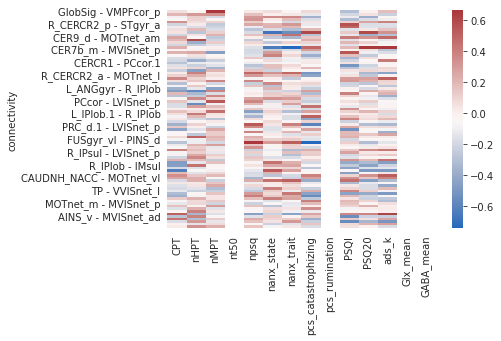

In [44]:
sns.heatmap(corrmtx.T, cmap=sns.color_palette("vlag", as_cmap=True))

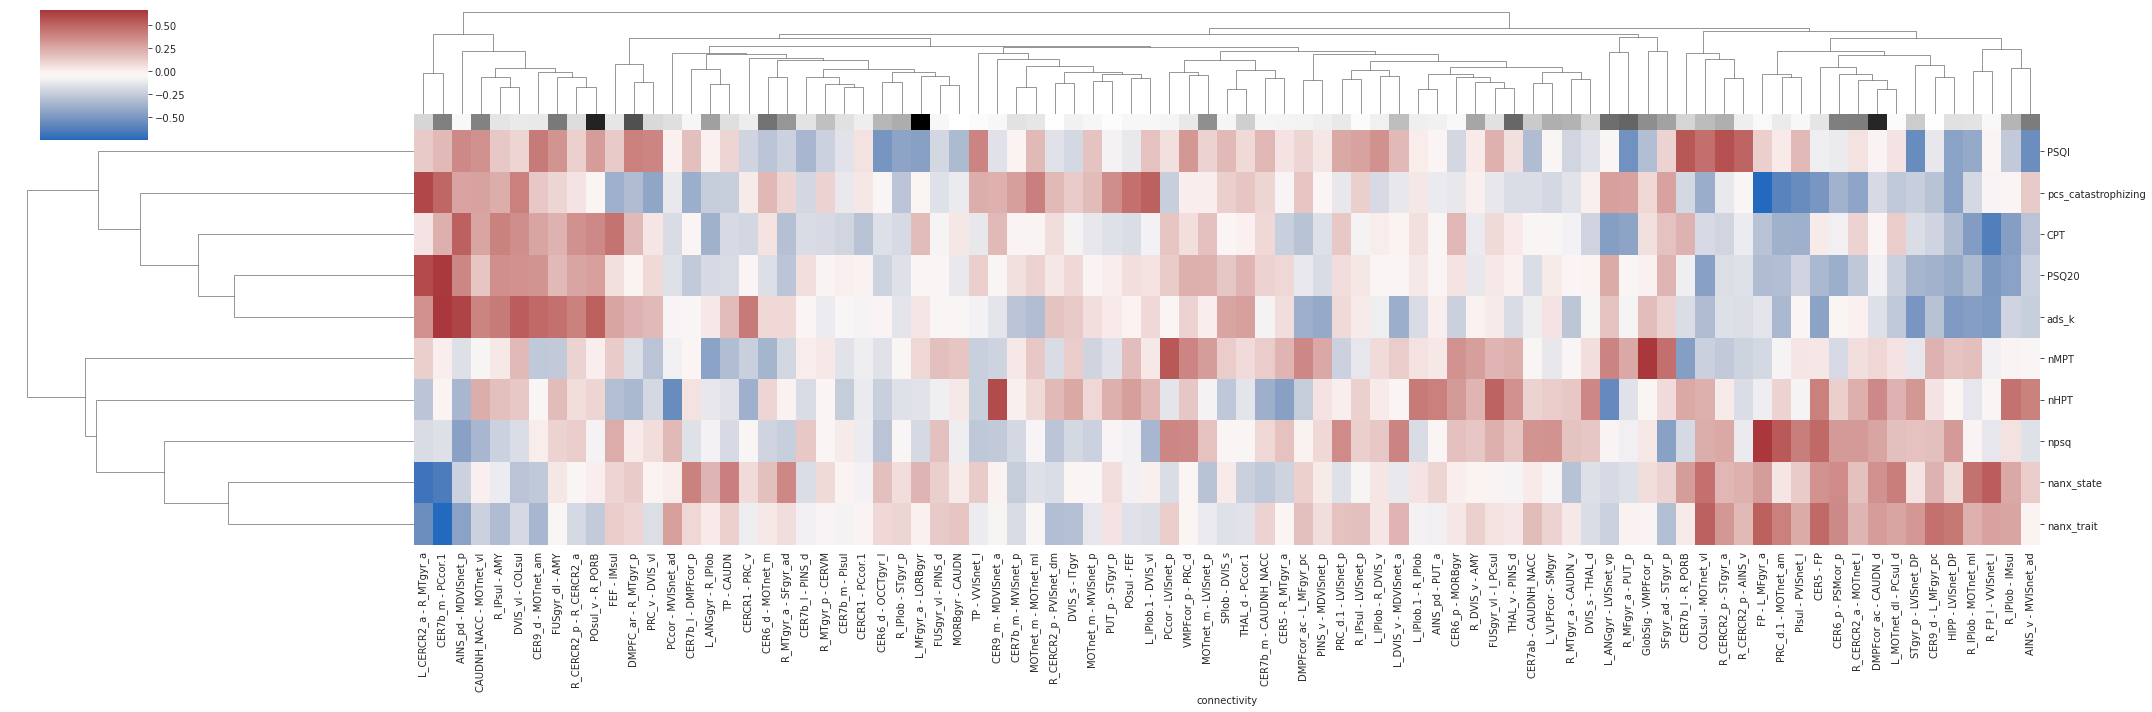

In [45]:
norm = Normalize()
sns.clustermap(corrmtx.dropna(), cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [46]:
#Importing libraries
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram , linkage

In [47]:
#Linkage Matrix
Z = linkage(corrmtx.T, method = 'ward')
#plotting dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(Z, labels=corrmtx.columns)
plt.title('Dendrogram')
plt.ylabel('Euclidean distance')
plt.xticks(fontsize = 12)
plt.show()


ValueError: The condensed distance matrix must contain only finite values.

In [ ]:
Z=pd.DataFrame(Z, index=corrmtx.columns)

In [ ]:
corrmtx.shape

In [ ]:
Z